In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ['PRJ'] = "/Users/ymohit/skigp/"

import math
import scipy
import numpy as np
import fastmat as fm

import matplotlib.gridspec as gridspec
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")
from pylab import rcParams
from matplotlib import pyplot as plt
from IPython.core.display import  HTML

np.random.seed(1337)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
## Loading modules from source 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from fkigp.dataloader import DataLoader
from fkigp.configs import DatasetType, Structdict, Frameworks, GsGPType
from fkigp.gps.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from fkigp.gps.constraints import softplus, DEFAULT_SOFTPLUS_VALUE
from fkigp.gridutils import get_basis
from fkigp.gps.gpbase import GpModel
from fkigp.gps.gpoperators import KissGpLinearOperator, GsGpLinearOperator

from fkigp.cgvariants import bfcg, bcg 

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Loading simple sine dataset 

In [3]:
## Loading sound dataset and computing kernel matrix for sound datast

class KFunc(GpModel):
    def __init__(self, grid, dtype):
        super().__init__()
        self.covar_module = GridInterpolationKernel(
            base_kernel=ScaleKernel(RBFKernel(ard_num_dims=1)),
            grid=grid,
            dtype=dtype,
            num_dims=1
        )
            
def compute_K(train_x, grid):
    kfunc = KFunc(grid=grid, dtype=train_x.dtype)
    hypers = {
    'covar_module.base_kernel.raw_outputscale': 1.1689740419387817, 
    'covar_module.base_kernel.base_kernel.raw_lengthscale':-1.002593994140625
    }
    kfunc.initialize(**hypers)
    return kfunc.covar_module._inducing_forward(is_kmm=True)
    

config = Structdict()
config['data_type'] = DatasetType.SINE
config['num_dims'] = 1
config['one_dim_num_points'] = 1000
data_loader=DataLoader(config=config)

train_x, train_y, test_x, test_y = data_loader.get_data()
grid =  [(-1, 1, 30)]
W = get_basis(train_x, grid)
w_x = get_basis(test_x, grid)
sigma = softplus(-5.12708854675293/2)
K_u = compute_K(train_x, grid)


## KISSGP posterior mean inference: 
### mu_x* =  w__x* KW^T(WKW^T + sigma^2 I)-1 y

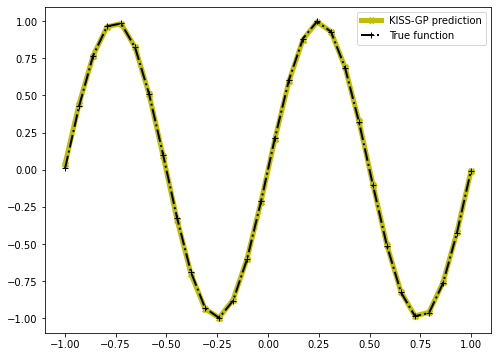

In [4]:
from fkigp.cgvariants import bcg 

kissgp_op = KissGpLinearOperator(W, K_u, sigma, train_x.dtype)
kissgp_pred = w_x*kissgp_op.kmm_matvec(kissgp_op.WT * bcg(kissgp_op, train_y, tol=1e-4))

plt.figure(figsize=(8, 6))
plt.plot(test_x, kissgp_pred, 'yX-', linewidth=5, label='KISS-GP prediction')
plt.plot(test_x, test_y, 'k+-.', linewidth=2, label='True function')
plt.legend(loc='upper right')
plt.show()

## Recall GSGP operator: KWTW + sigma^2 I. 
### Claim: we don't need access to W or X once we have sufficient statistics, i.e., W^TW and W^ty. 
### Step-1: Let's compute sufficient statistics first

In [5]:
WT_times_W = fm.Sparse((W.T * W).tocsr())
WT_times_Y = W.T * train_y
YT_times_Y = train_y.T @ train_y

### Step-2: Posterior inference using GSGP operator 

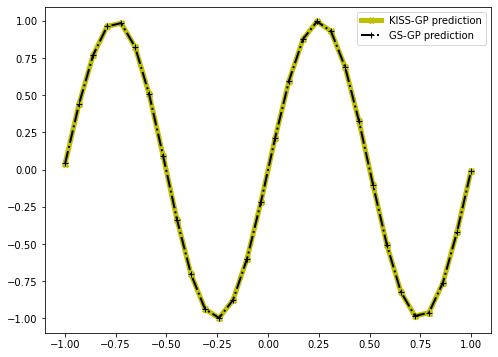

In [6]:
gsgp_op = GsGpLinearOperator(WTW=WT_times_W, kmm=K_u, sigma=sigma, dtype=train_x.dtype)

sigma2 = sigma ** 2
b_hat = gsgp_op.kmm_matvec(WT_times_Y).real
r0_hat = - (1 / sigma2) * b_hat
x_diff = bfcg(gsgp_op, r0_hat.squeeze(), yty=YT_times_Y,  tol=1e-4)

gsgp_pred = w_x*((1 / sigma2) * (gsgp_op.kmm_matvec(WT_times_Y)).real + gsgp_op.kmm_matvec(x_diff)) 
    
plt.figure(figsize=(8, 6))
plt.plot(test_x, kissgp_pred, 'yX-', linewidth=5, label='KISS-GP prediction')
plt.plot(test_x, gsgp_pred, 'k+-.', linewidth=2, label='GS-GP prediction')
plt.legend(loc='upper right')
plt.show()